HW11 BY KATE CAULEY

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.dates as mdates

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Reading the Data

In [5]:
#from IPython.display import Image
#Image(filename = "Ridetypes.png")

In [6]:
mtaRides = np.load('MTA_Fare.npy')

In [7]:
mtaRides.shape

(600, 23, 194)

In [8]:
mtaRides = mtaRides.astype(float)

In [9]:
mtaRides[mtaRides == -1.] = np.NaN

In [10]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [11]:
#May 19, 2010 - Friday Feb 19, 2014 - Friday
dates = pd.date_range(start='05/19/2010', periods=194, freq='W-FRI')
dates

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

In [12]:
np.nansum(mtaRides,axis=0).shape

(23, 194)

In [13]:
np.nansum(mtaRides,axis=1).shape

(600, 194)

In [14]:
countPerCardType = np.nansum(mtaRides,axis=0)
countPerStation = np.nansum(mtaRides,axis=1)

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

In [15]:
countPerStation.shape

(600, 194)

In [16]:
# Sum per week
allStations = np.nansum(countPerStation,axis=0)
allStations.shape

(194,)

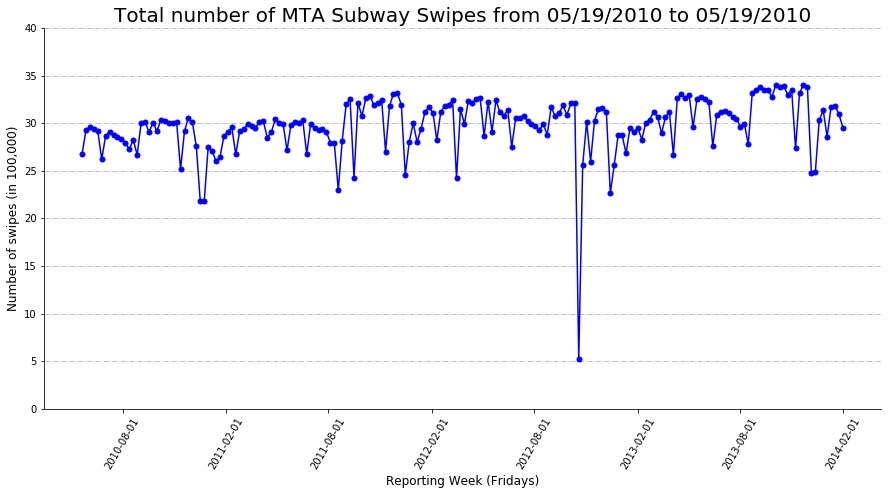

In [17]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.plot(dates, allStations/1e6, '.-', ms=10, color='blue')

ax.set_xlabel("Reporting Week (Fridays)", fontsize=12)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=12)

ax.set_xticklabels(dates, rotation=60, fontsize=10)

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylim([0,40])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total number of MTA Subway Swipes from 05/19/2010 to 05/19/2010", fontsize=20)

ax.grid(axis='y', linestyle='-.');

## Figure 1. Total number of MTA Subway Swipes from May 19, 2010 to February 19, 2010
This plot shows the total number of MTA subway swipes per week from May 19, 2010 to February 19, 2014. There is one very obvious outlier around October 2012. 

In [18]:
popMean = np.nanmean(allStations)
popStd = np.nanstd(allStations)

print("Mean: {:.4f}".format(popMean))
print("Standard Deviation: {:.4f}".format(popStd))

Mean: 29781349.8711
Standard Deviation: 2983960.4217


In [19]:
thresholds = [popMean + 3 * popStd, 
              popMean - 3 * popStd]
print("Thresholds (3std): {}".format(thresholds))

Thresholds (3std): [38733231.136236683, 20829468.606031362]


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

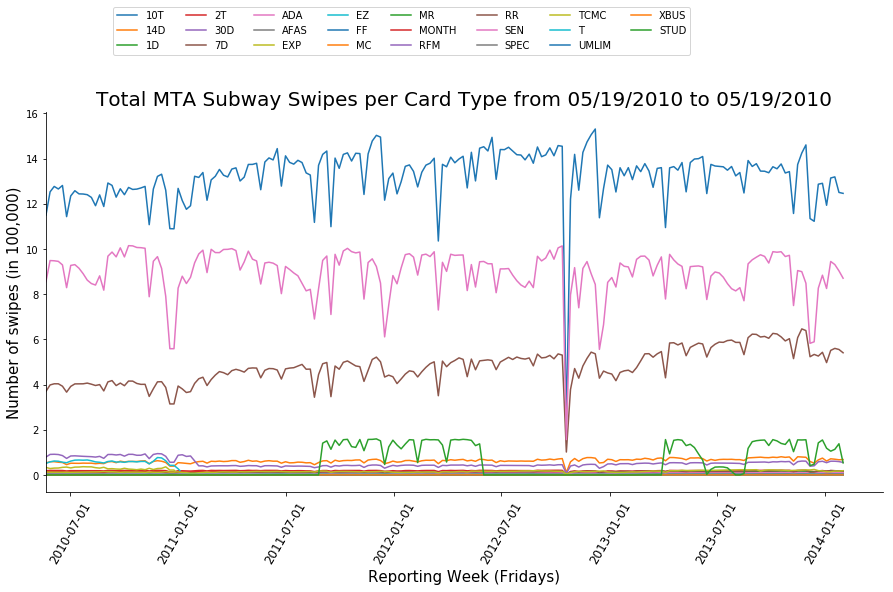

In [20]:
fig = pl.figure(figsize=(15,7))
ax = fig.add_subplot(111)

for y_arr, label in zip(countPerCardType/1e6, ridetype):
    ax.plot(dates, y_arr, label=label.upper())

ax.set_xticklabels(dates, rotation=60, fontsize=12)
ax.set_xlim(dates[0])

ax.set_xlabel("Reporting Week (Fridays)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

pl.legend(bbox_to_anchor=(0, 1.15, 0.77, .102), loc=4,
           ncol=8, borderaxespad=0., fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total MTA Subway Swipes per Card Type from 05/19/2010 to 05/19/2010", fontsize=20);

## Figure 3. Total number of MTA Subway Swipes per Card Type from 05/19/2010 to 05/19/2010¶

This is a plot of the total number of MTA subways swipes per card type from May 19, 2010 to February 19, 2014 (194 weeks). Notice the 3 card types which seem to have more use as compared to the other 20 card types. 



In [21]:
#Counter per card type into DF
dfCardType = pd.DataFrame(countPerCardType.T)
dfCardType.set_index(dates, inplace=True)
dfCardType.columns = ridetype

In [22]:
dfCardType.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-21,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-28,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2010-06-04,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
2010-06-11,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
2010-06-18,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [23]:
cardType_rmean = dfCardType.rolling(center=False, axis=0, window=10).mean()
cardType_rstd = dfCardType.rolling(center=False, axis=0, window=10).std()

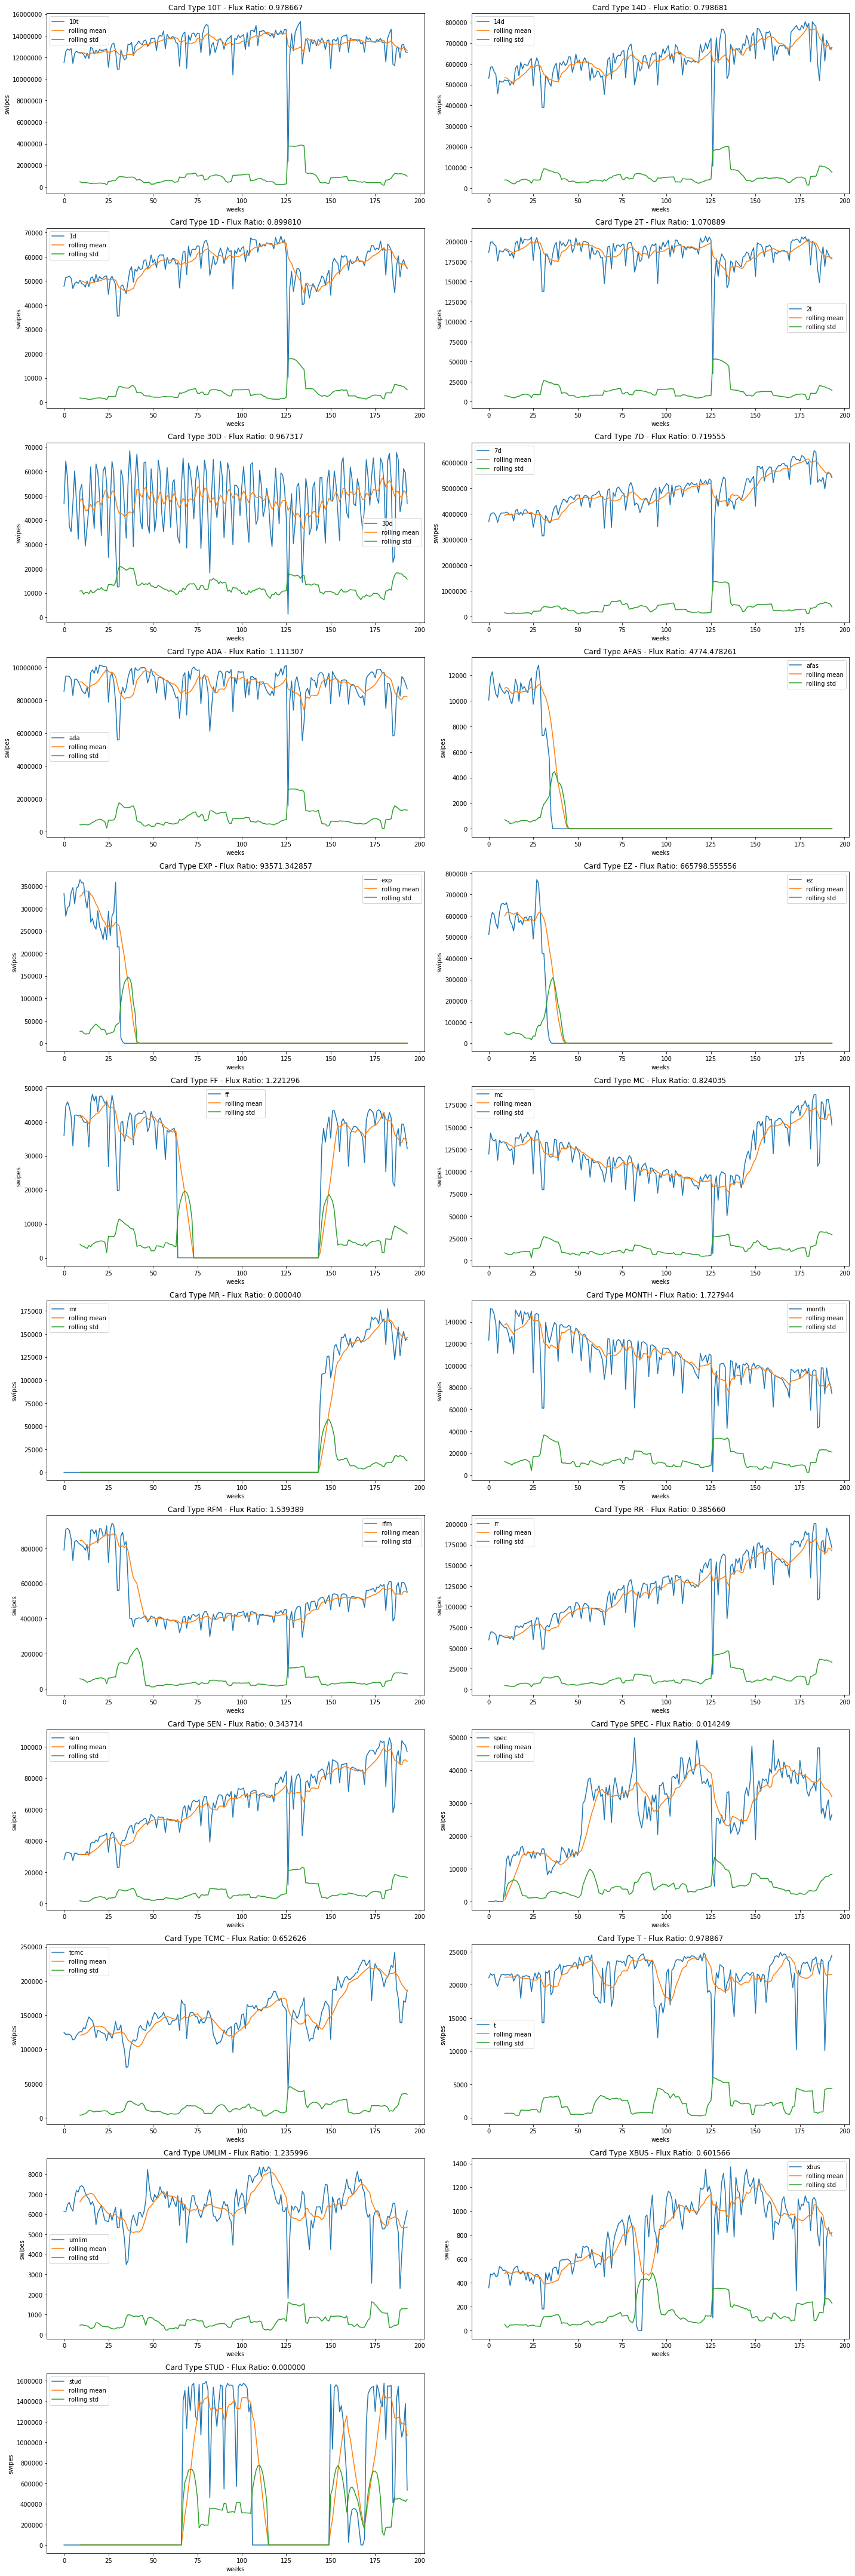

In [24]:
columns = dfCardType.columns
fig = pl.figure(figsize=(20,60))
ratio = dict()

for i in range(len(columns)):
    ts = dfCardType.iloc[:,i]
    ts_rmean = cardType_rmean.iloc[:,i]
    ts_rstd = cardType_rstd.iloc[:,i]
    
    ts_ratio = ts.iloc[0:10].mean() / ts.iloc[-10:].mean()
    ratio[ts.name.upper()] = ts_ratio
    
    ax = fig.add_subplot(12,2,i+1)
    ax.plot(np.arange(len(ts)), ts, label=columns[i])
    ax.plot(np.arange(len(ts)), ts_rmean, label="rolling mean")
    ax.plot(np.arange(len(ts)), ts_rstd, label="rolling std")
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_xlabel('weeks')
    ax.set_ylabel('swipes')
    ax.set_title('Card Type {} - Flux Ratio: {:.6f}'.format(ts.name.upper(), ts_ratio))
    pl.legend(fontsize=10)

pl.tight_layout()

## Figure 4. Individual Plots of MTA Subway Swipes per Card Type with Rolling Mean and Rolling Standard Deviation 

In the 23 subplots, there is a trend of each card type individually. The plots show which card types are stationary, which have increased in usage and which have decreased in useage.

AFAS, EXP and EZ card types decreas around the 25th week. Howeverm MR only starts to be used around 140th week. 

The 30-Day card type looks to be a stationary time series. 

In [25]:
def test_stationarity(timeseries):
    adftest = sm.tsa.adfuller(timeseries)
    
    if (adftest[0] > adftest[4]['5%']):
        print("{} \t | The series is not stationary".format(timeseries.name))
    else:
        print("{} \t | The series is stationary".format(timeseries.name))

In [26]:
for i in range(len(columns)):
    test_stationarity(dfCardType.iloc[:,i])

10t 	 | The series is stationary
14d 	 | The series is not stationary
1d 	 | The series is not stationary
2t 	 | The series is stationary
30d 	 | The series is stationary
7d 	 | The series is not stationary
ada 	 | The series is stationary
afas 	 | The series is not stationary
exp 	 | The series is stationary
ez 	 | The series is not stationary
ff 	 | The series is not stationary
mc 	 | The series is not stationary
mr 	 | The series is not stationary
month 	 | The series is not stationary
rfm 	 | The series is not stationary
rr 	 | The series is not stationary
sen 	 | The series is not stationary
spec 	 | The series is not stationary
tcmc 	 | The series is stationary
t 	 | The series is stationary
umlim 	 | The series is stationary
xbus 	 | The series is not stationary
stud 	 | The series is not stationary


In [27]:
for k, v in sorted(ratio.items(), key=lambda kv: (-kv[1], kv[0])):
    print("{} \t | {:.6f}".format(k, v))

EZ 	 | 665798.555556
EXP 	 | 93571.342857
AFAS 	 | 4774.478261
MONTH 	 | 1.727944
RFM 	 | 1.539389
UMLIM 	 | 1.235996
FF 	 | 1.221296
ADA 	 | 1.111307
2T 	 | 1.070889
T 	 | 0.978867
10T 	 | 0.978667
30D 	 | 0.967317
1D 	 | 0.899810
MC 	 | 0.824035
14D 	 | 0.798681
7D 	 | 0.719555
TCMC 	 | 0.652626
XBUS 	 | 0.601566
RR 	 | 0.385660
SEN 	 | 0.343714
SPEC 	 | 0.014249
MR 	 | 0.000040
STUD 	 | 0.000000


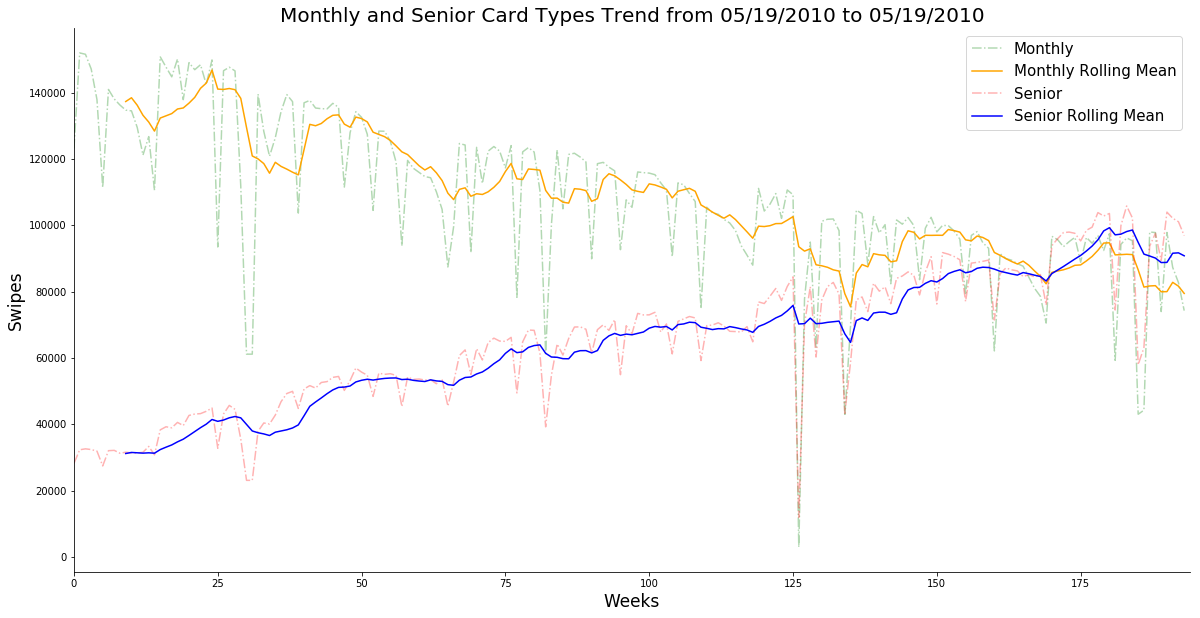

In [28]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(np.arange(len(dfCardType['month'])), dfCardType['month'], label="Monthly", c='green', linestyle='-.',alpha=0.3)
ax.plot(np.arange(len(dfCardType['month'])), cardType_rmean['month'], label="Monthly Rolling Mean", c='orange')
ax.plot(np.arange(len(dfCardType['sen'])), dfCardType['sen'], label="Senior", c='red',linestyle='-.', alpha=0.3)
ax.plot(np.arange(len(dfCardType['sen'])), cardType_rmean['sen'], label="Senior Rolling Mean", c='blue')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.set_xlabel('Weeks', fontsize=17)
ax.set_ylabel('Swipes', fontsize=17)
ax.set_xlim(0,194)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Monthly and Senior Card Types Trend from 05/19/2010 to 05/19/2010", fontsize=20);
pl.legend(fontsize=15);

## Figure 5. Rolling Mean of MTA Subway Swipes of Monthly and Senior Citizen/Disabled card types with the actual time series.

The orange solid line is the rolling mean for the total MTA subway swipes for the Monthly card type which shows a steady decrease in popularity over the weeks. 
The green dash-dotted line shows the actual time series for the Monthly card type for the span of 194 weeks. 

The blue solid line is the rolling mean for the total MTA subway swipes for the Senior Citizen/Disabled card type. This card type shows a steady increase in popularity. The light red dash-dotted line is the time series for the Senior Citizen/Disabled card type. This card type is at 0.34 which means it was increases popularity from the beginning to the end.

# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features

In [29]:
#build two random forest models- make a prediction 

In [30]:
#pandas df

In [33]:
mtaRides.shape

(600, 23, 194)

In [37]:
# Convert a df where row = 600*23
m,n,r = mtaRides.shape #-1
out_arr = np.column_stack((np.repeat(np.arange(m),n),mtaRides.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

out_df = out_df.iloc[:, 1:].copy() # removing the column which indicates station number

out_df

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,43608.0,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1425.0,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,217.0,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,576.0,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,290.0,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0
5,17654.0,20249.0,20325.0,20852.0,20079.0,21256.0,20775.0,21002.0,21543.0,21913.0,...,17107.0,20969.0,26134.0,14524.0,13650.0,11904.0,12894.0,14153.0,13389.0,15042.0
6,32369.0,42599.0,41423.0,42667.0,42415.0,38055.0,42020.0,41372.0,41836.0,39325.0,...,17915.0,11791.0,11797.0,18286.0,19460.0,16558.0,19710.0,19722.0,18898.0,17518.0
7,59.0,60.0,67.0,61.0,51.0,50.0,58.0,46.0,39.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6733.0,5487.0,6237.0,7272.0,7752.0,9348.0,7783.0,8174.0,8749.0,9028.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1835.0,2320.0,2521.0,2759.0,2673.0,3561.0,3823.0,4313.0,4273.0,3497.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Mean and Std. Deviation of each time series (i.e., 194) for each station
out_df['mean_ts'] = out_df.mean(axis=1)
out_df['std_ts'] = out_df.std(axis=1)

out_df.head(25)

,1,2,3,4,5,6,7,8,9,10,...,187,188,189,190,191,192,193,194,mean_ts,std_ts
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,58586.885417,17761.092039
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1828.182292,510.965674
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0,237.322917,66.531712
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0,737.656250,187.212631
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0,293.140625,140.824159
5,17654.0,20249.0,20325.0,20852.0,20079.0,21256.0,20775.0,21002.0,21543.0,21913.0,...,26134.0,14524.0,13650.0,11904.0,12894.0,14153.0,13389.0,15042.0,20033.307292,5934.298672
6,32369.0,42599.0,41423.0,42667.0,42415.0,38055.0,42020.0,41372.0,41836.0,39325.0,...,11797.0,18286.0,19460.0,16558.0,19710.0,19722.0,18898.0,17518.0,30557.296875,10025.548001
7,59.0,60.0,67.0,61.0,51.0,50.0,58.0,46.0,39.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.572917,18.735130
8,6733.0,5487.0,6237.0,7272.0,7752.0,9348.0,7783.0,8174.0,8749.0,9028.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,977.171875,2314.857230
9,1835.0,2320.0,2521.0,2759.0,2673.0,3561.0,3823.0,4313.0,4273.0,3497.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,431.281250,991.813120


In [39]:
labels = [[i for i in range(0, 23)] for j in range(0, 600)] # Generating a list of labels
flat_labels = [item for sublist in labels for item in sublist] # Flattening them

len(flat_labels)

13800

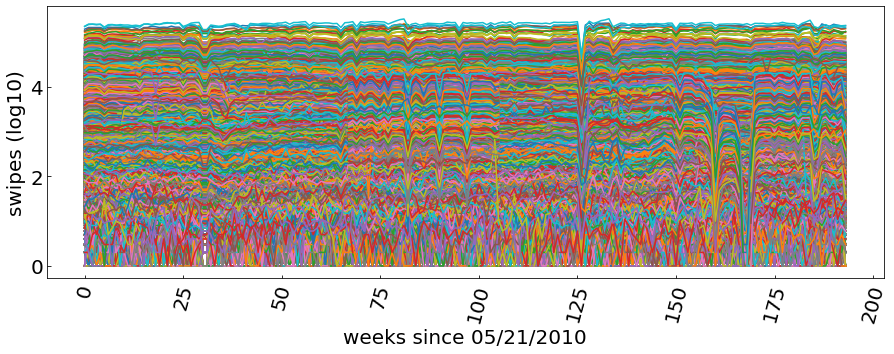

In [12]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


#### Figure 2: time series for all ride types and all stations in semi-log space

13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


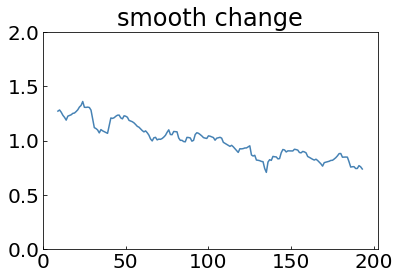

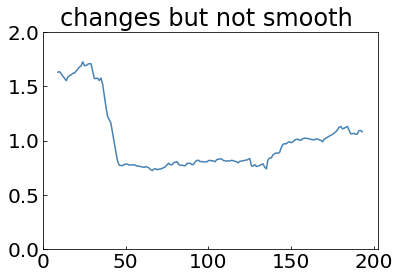

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

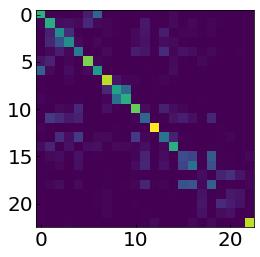

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

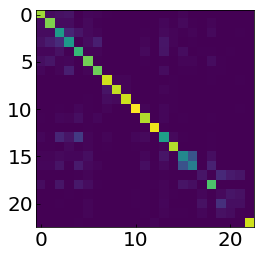

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   